# Data Mining - Homework 2 - Recommendation Systems

Student: Mohammad Sami ALEsh - Date: Sat 12/6/2021

**Note**: This homework is based on [article](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b) about "Building and Testing recommender systems with Surprise"

## Dataset Preparation

Mounting My Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

[dataset](https://drive.google.com/file/d/196W2kDoZXRPjzbTjM6uvTidn6aTpsFnS) **file_id** on Drive:

> 196W2kDoZXRPjzbTjM6uvTidn6aTpsFnS (json.gz)

> 1--J5u7saHIod_JAX74wb3eBv342r-xdZ (csv)

In [5]:
!gdown --id 1--J5u7saHIod_JAX74wb3eBv342r-xdZ

copy downloaded dataset from colab to a specific folder in my Drive

In [ ]:
import shutil
shutil.move("/content/goodreads_reviews_spoiler.csv", "/content/gdrive/My Drive/DRIVE/Data Mining dataset/")

Loading Dataset

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Load dataset
df = pd.read_csv("/content/gdrive/MyDrive/DRIVE/Data Mining dataset/goodreads_reviews_spoiler.csv") 

# Remove unwanted columns to reduce RAM usage
df.drop(['timestamp', 'review_sentences', 'has_spoiler', 'review_id', 'review_sentences_cleaned'], axis=1, inplace=True)

df.head(3)

,user_id,rating,book_id
0,8842281e1d1347389f2ab93d60773d4d,5,18245960
1,8842281e1d1347389f2ab93d60773d4d,3,16981
2,8842281e1d1347389f2ab93d60773d4d,3,28684704


Visualize ratings

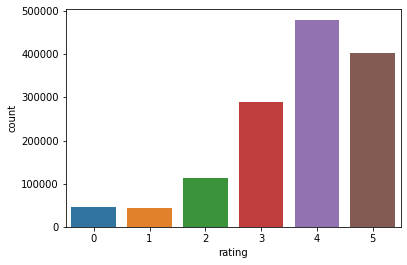

In [8]:
sns.countplot(x ='rating', data = df)
plt.show()

We notice that we have really high rating (4 & 5 stars) in dataset 😎

#### **Optimization trick**:
To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated books and rarely rating users.

In [9]:
min_book_ratings = 50
filter_books = df['book_id'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
prev_shape = df.shape
df = df[(df['book_id'].isin(filter_books)) & (df['user_id'].isin(filter_users))]
new_shape = df.shape

print('The original data frame shape:\t', prev_shape)
print('The new data frame shape:\t', new_shape)

The original data frame shape:	 (1378033, 3)
The new data frame shape:	 (804436, 3)


### Surprise library
We’ll be working with our dataset to develop recommendation system algorithms, with the [Surprise](http://surpriselib.com/) library, which was built by [Nicolas Hug](http://nicolas-hug.com/).

In [ ]:
!pip install scikit-surprise

In [28]:
import numpy as np
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, accuracy

# Algorithms
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

To load a data set from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating

In [29]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)

**NormalPredictor**:

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal

**BaselineOnly:**

BaselineOnly algorithm predicts the baseline estimate for given user and item.

### **k-NN algorithms**

**KNNBasic**

**KNNWithMeans**:

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

**KNNWithZScore:**

KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user

**KNNBaseline:**

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### **Matrix Factorization-based algorithms**
**SVD**:

SVD algorithm is equivalent to Probabilistic Matrix Factorization

**SVDpp**:

The SVDpp algorithm is an extension of SVD that takes into account implicit ratings

**NMF**:

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD

**Slope One**:

SlopeOne is a straightforward implementation of the SlopeOne algorithm.


**Co-clustering**:

Coclustering is a collaborative filtering algorithm based on co-clustering.


**Algorithms benchmark:**

We will use “[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)” as our accuracy metric for the predictions.

In [32]:
benchmark = []

all_algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

# We will test small set of algorithms for quick excution... (Note: you can replace bunch_of_algorithms with all_algorithms array to excute all algorithms)
bunch_of_algorithms = [SVD(), SlopeOne(), NormalPredictor(), KNNBasic(), BaselineOnly()]

for algorithm in bunch_of_algorithms:
  print('Benchmarking', str(algorithm).split(' ')[0].split('.')[-1], '.....')

  # Perform cross validation
  results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
  
  # Get results & append algorithm name
  tmp = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
  benchmark.append(tmp)

Benchmarking SVD .....
Benchmarking SlopeOne .....
Benchmarking NormalPredictor .....
Benchmarking KNNBasic .....
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Benchmarking BaselineOnly .....
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


**Results:**

In [33]:
print(pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse'))

                 test_rmse   fit_time  test_time
Algorithm                                       
BaselineOnly      1.080882   3.530842   2.920828
SlopeOne          1.084817   6.533543  29.973119
SVD               1.101910  26.601770   3.422570
KNNBasic          1.149960   9.019449  55.925618
NormalPredictor   1.645241   1.026096   3.222604


BaselineOnly algorithm gave us the best RMSE, therefore, we will train and predict with BaselineOnly and use Alternating Least Squares ([ALS](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/))

In [34]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (1.7330634593963623, 2.106426239013672, 2.1538631916046143),
 'test_rmse': array([1.07887527, 1.07980704, 1.0810567 ]),
 'test_time': (3.398244619369507, 2.641448736190796, 3.4191811084747314)}

Calculating precisions & recall using BaseLineOnly

In [35]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.0801


1.0801326643285962

In [36]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

In [38]:
precisions, recalls = precision_recall_at_k(predictions)
print('precisions: ', precisions)
print('recalls: ', recalls)
print('precisions: ',np.sum(list(precisions.values())) / len(precisions))
print('recalls: ',np.sum(list(recalls.values())) / len(recalls))

precisions:  {'b203e4fba0ee0d5843b229781c884234': 0.9, '7125a5258b45d6c194fa3322473ef212': 0.8, '009235f414f42cfd0f76282f6aefe6c1': 0.8, '0452775e5c9dc326d5f0f3526c9fe473': 0.9, '9f9d0f6e9a6a5797a252ef81abc9421c': 1.0, '19b461e3cf3388412aadcc8d6ffb2b4a': 0.7, 'db0b3861db58480127e72310eb605a9d': 0.7, 'b54fc30bf74b2a517d8e5239666689e4': 0.7, 'a410bfaed52d4b018939ccf8352a346e': 0.9, '9ac0bac35da4f9084886d60f7978599c': 0.8, 'b76565fc5c9da884a84c63d7453f5f43': 0.8, '98fb70230d78a68413e19c8d1560818c': 0.8, '59a538ebd5ccd334b4f65766c58f4a9a': 0.8, '2d58664f983e421f4f3aa3ce8bdd7949': 0.9, 'd54dde6fc00fe8aeb075a7aeda8ea9f6': 0.5, 'b0b13c32354ff3b766933707cab6a09c': 0.6666666666666666, 'dcffeab5847efb63244722253495da06': 0.8571428571428571, 'c612f9e3616aadf298f8192543114915': 0.9, 'd9919307325e8357c022e794cb666ee3': 0, 'ac6f11f98bde811d54a956aa28e85956': 0.8, '4eb22dfac14a789fde5a4f8ee76b3976': 0.7777777777777778, '3e95836ecca402825647f087c52cc524': 0.9, '24ec19e5301ffc5c8a030eac0d7a4ed2': 0.333